<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): GPS calculation

> Analyses of the dataset with data from patients with Diabetic Neuropathy before intervention (102 individuals) compared with data from Fukuchi et al. (2018), a dataset of 42 healthy volunteers (24 young adults and 18 older adults) who walked overground at comfortable speeds.

## Python setup

In [1]:
#@title ### Import libraries {display-mode: "form"}
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
import pingouin as pg # statistics
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy
try:
    import spm1d
except:
    !pip install -q spm1d
    import spm1d

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}', f' spm1d {spm1d.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:53:10) [GCC 13.3.0] on linux
 numpy 2.2.2
 scipy 1.15.1
 pandas 2.2.3
 spm1d 0.4.33
12/02/2025 04:51:18


In [2]:
#@title ### Environment configuration {display-mode: "form"}
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# angle convention
planes  = ['Sagittal', 'Frontal', 'Transverse']
labels_gps_kin = np.array(['Pelvic Tilt', 'Pelvic Obliquity', 'Pelvic Rotation',
                           'Hip Flexion', 'Hip Adduction', 'Hip Rotation',
                           'Knee Flexion', 'Ankle Dorsiflexion', 'Foot Progression', 'GPS'])
labels_gps_mom = np.array(['Hip moment', 'Knee moment', 'Ankle moment', 'GPS moment'])
labels_kin  = np.array([['Pelvic Tilt ($^o$)\npost(-)/ant(+)',
                         'Pelvic Obliquity ($^o$)\ndown(-)/up(+)',
                         'Pelvic Rotation ($^o$)\next(-)/int(+)'],
                        ['Hip Flexion ($^o$)\next(-)/flex(+)',
                         'Hip Adduction ($^o$)\nabd(-)/add(+)',
                         'Hip Rotation ($^o$)\next(-)/int(+)'],
                        ['Knee Flexion ($^o$)\next(-)/flex(+)',
                         'Ankle Dorsiflexion ($^o$)\nplantarflex(-)/dorsiflex(+)',
                         'Foot Progression ($^o$)\nint(-)/ext(+)']])
labels_mom = np.array([['Hip ($Nm/BM$)\next(-)/flex(+)',
                        'Knee ($Nm/BM$)\next(-)/flex(+)',
                        'Ankle ($Nm/BM$)\nplantarflex(-)/dorsiflex(+)']]).T

if (path := Path('/home/marcos/adrive/Python/projects/labimph/gait_score')).exists() is False:
    path = Path('/users/marcos/adrive/Python/projects/labimph/gait_score')
print(f'Path: {path}')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

Path: /home/marcos/adrive/Python/projects/labimph/gait_score


In [3]:
#@title ### Helping functions {display-mode: "form"}
def read_data(path2, fname, variable=None):
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/metadata_{fname}.csv'
        print(f'Loading data from {url}')
        metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    else:
        metadata = pd.read_csv(path2 /  f'metadata_{fname}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{variable}_{fname}.nc'
        #print(f'Loading data from {url}')
        !wget {url}
        da = xr.open_dataarray(f'{variable}_{path2.name}.nc')
    else:
        da = xr.open_dataarray(path2 / f'{variable}_{fname}.nc')
    return metadata, da


def gps_calc(da2, ref, metadata2, labels_gps):
    """
    """
    subjects = metadata2['Subject'].unique()
    NS = subjects.size
    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)
    gvs = np.full((NS, labels_gps.size), np.nan)
    for s, subject in enumerate(subjects):
        x = da2.sel(Subject=subject).values.reshape(time.size, len(joints)*len(axes))
        gvs[s, :-1] = RMSD(x, ref.values)
    
    gvs[:, -1] = np.sqrt(np.mean(gvs[:, :-1]**2, axis=1))
    gvs = pd.DataFrame(data=gvs, index=subjects, columns=labels_gps)
    #gvs_m = np.sqrt(np.mean(gvs**2, axis=0))
    #gvs_std = np.sqrt(np.std(gvs**2, axis=0, ddof=1))
    gvs_m = np.percentile(gvs, 50, axis=0)
    gvs_std = np.percentile(gvs, [25, 75], axis=0)

    return gvs, gvs_m, gvs_std
    
    
def plot_gps(gvs, gvs_m, gvs_std, metadata2, path2, hist=True, MAP=True, prefix='', units='$^o$'):
    """
    """
    if units == '$^o$':
        prefix2 = 'Angles: '
    else:
        prefix2 = 'Moments of force: '
    subjects = metadata2['Subject'].unique()
    NS = subjects.size    
    if hist:
        if gvs.shape[1] > 5:
            axs = gvs.hist(layout=(2, 5), figsize=(12, 5))
        else:
            axs = gvs.hist(layout=(1, 4), figsize=(10, 3))
        
        for ax in axs[:, 0]:
            ax.set_ylabel('Frequency')
        for ax in axs[-1, :]:
            ax.set_xlabel(f'RMS difference ({units})')        
        plt.suptitle(f'{prefix}Histograms for GVS and GPS values ({NS} subjects)')
        plt.tight_layout()
        plt.show()
    if MAP:
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        x = np.r_[np.arange(1, gvs.shape[1]), gvs.shape[1]+1]
        #x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
        axs.bar(x=x, height=gvs_m, yerr=gvs_std, width=.8, edgecolor=None, capsize=5)
        axs.set_ylabel(f'RMS difference ({units})')
        axs.set_xlabel('')
        axs.xaxis.set_ticks(x)
        axs.set_xticklabels(gvs.columns.values, rotation=45, ha='right')
        axs.grid(True)
        plt.suptitle(f'{prefix}Movement analysis profile ({NS} subjects)')
        plt.tight_layout()
        plt.show()   


def plot_ensembles2(da2, metadata, path2, mean=False, ref=None, prefix=''):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)

    NS = metadata['Subject'].unique().size
    NT = metadata['Subject'].shape[0]
    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    text = f'{path2.name}:'
    if ref is not None:
        ref_m =  ref.values[:, 0::2]
        ref_sd = ref.values[:, 1::2]
    if mean:
        text = f'{prefix}Joint angles during walking (mean$\\pm$1SD across subjects, {NS} subjects with neuropathy) and mean of control'
    else:
        text = f'{prefix}Subjects\' joint angles during walking (median across trials, {NS} subjects, {NT} trials)'
    fig.suptitle(text, fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            
            if ref is not None:
                axs[j, xyz].plot(time, ref_m[:, 3*j+xyz], color=colors[1], alpha=.5, lw=3, label='Control')
                if mean:
                    axs[j, xyz].fill_between(time,
                                             ref_m[:, 3*j+xyz] + ref_sd[:, 3*j+xyz],
                                             ref_m[:, 3*j+xyz] - ref_sd[:, 3*j+xyz],
                                             facecolor=colors[1], alpha=.3, edgecolor='none')
            
            if mean:
                dam = da2.reduce(np.nanmean, dim='Subject')
                dastd = da2.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)
                axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3, label='Neuropathy')
                axs[j, xyz].fill_between(time,
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         facecolor=colors[0], alpha=.6, edgecolor='none')
            else:
                axs[j, xyz].plot(time, da2.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.6, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    if ref is not None:
        axs[0, 1].legend(loc='upper right', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        if mean:
            fig.savefig(f'{path2}Angles_msd_Subjects_{prefix}.png', bbox_inches='tight')
        else:
            fig.savefig(f'{path2}AnglesSubjectsG_{prefix}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()



def plot_ensembles(da2, metadata, path2, mean=False, labels=None, ref=None, prefix='', variable=None):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da2['Time'].values
    joints = list(da2.Joint.values)
    axes = list(da2.Axis.values)

    NS = metadata['Subject'].unique().size
    NT = metadata['Subject'].shape[0]
    fig, axs = plt.subplots(len(joints), len(axes), figsize=(len(axes)*4, 9), sharex=True, squeeze=False)
    text = f'{path2.name}:'
    if ref is not None:
        ref_m =  ref.values[:, 0::2]
        ref_sd = ref.values[:, 1::2]
    if mean:
        text = f'{prefix}Joint {variable} during walking (mean$\\pm$1SD across subjects, {NS} subjects with neuropathy) and mean of control'
    else:
        text = f'{prefix}Subjects\' joint {variable} during walking (median across trials, {NS} subjects, {NT} trials)'
    fig.suptitle(text, fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            
            if ref is not None:
                axs[j, xyz].plot(time, ref_m[:, len(axes)*j+xyz], color=colors[1], alpha=.5, lw=3, label='Control')
                axs[j, xyz].fill_between(time,
                                         ref_m[:, len(axes)*j+xyz] + ref_sd[:, len(axes)*j+xyz],
                                         ref_m[:, len(axes)*j+xyz] - ref_sd[:, len(axes)*j+xyz],
                                         facecolor=colors[1], alpha=.3, edgecolor='none')
            
            if mean:
                dam = da2.reduce(np.nanmean, dim='Subject')
                dastd = da2.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)
                axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3, label='Neuropathy')
                axs[j, xyz].fill_between(time,
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                         facecolor=colors[0], alpha=.6, edgecolor='none')
            else:
                axs[j, xyz].plot(time, da2.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.6, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    if ref is not None:
        axs[0, 0].legend(loc='upper right', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        if mean:
            fig.savefig(f'{path2}Angles_msd_Subjects_{prefix}.png', bbox_inches='tight')
        else:
            fig.savefig(f'{path2}AnglesSubjectsG_{prefix}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()


def load_info(fname):
    info = pd.read_excel(fname)
    info = info[['ID', 'Age (y)', 'Height (m) ', 'Body Mass (kg)', 'Body Mass Index (kg/m2)', 'Sex', 'Time of diabetes onset',
           'FuzzyScoreT00 ', 'MNSIT00', 'EQ5DT00 ', 'FHSQFootPainT00 ', 'FHSQFootFunctionT00']]
    info = info.rename(columns={'ID': 'Subject', 'Age (y)': 'Age', 'Height (m) ': 'Height', 'Body Mass (kg)': 'Mass',
                                'Body Mass Index (kg/m2)': 'BMI', 'Time of diabetes onset': 'TDO', 'FuzzyScoreT00 ': 'FuzzyScore',
                                'MNSIT00': 'MNSI', 'EQ5DT00 ': 'EQ5D', 'FHSQFootPainT00 ': 'FHSQFootPain', 'FHSQFootFunctionT00': 'FHSQFootFunction'})
    if isinstance(info['Subject'][0], str):
        info['Subject'] = info['Subject'].str.replace('S', 'C')
    else:
        info['Subject'] = 'S' + info['Subject'].astype(str).str.zfill(2)
    info.set_index('Subject', drop=True, inplace=True)
    return info



def corr_heatmap(df, method='pearson', padjust='none'):
    """calculate r and plot
    """
    df_r = df.rcorr(method=method, padjust=padjust)
    df_r = df_r.replace('-', '1.0')
    mask = np.zeros_like(df_r, dtype=bool)
    mask[np.tril_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(14, 10)) 
    ax = sns.heatmap(df_r.where(mask).astype(float), annot=True, fmt=".2f", cmap='YlGnBu', ax=ax)
    # invert mask for the labels ('***' vals)
    labels = df_r.where(~mask).to_numpy()
    for (j, i), label in np.ndenumerate(labels):
        if isinstance(label, str):
            ax.text(i+0.5, j+0.5, label, fontdict=dict(ha='center', va='center', color='black', fontsize=20))
    plt.show()

## The Gait Proﬁle Score (GPS)

Baker et al. (2009) proposed the Gait Proﬁle Score (GPS) as an index of overall gait pathology.  
To calculate the GPS, first the Gait Variable Score (GVS) is determined as the RMS difference between a gait variable of a subject and the average of this gait variable for a sample with no gait pathology (reference).  
The Gait Proﬁle Score (GPS) is the RMS average of all GVS values.  
The Movement Analysis Proﬁle (MAP) is a plot with all GVS values and the GPS value of the subject and of the reference sample.  
Baker et al. suggested nine angular variables of gait for using in the GPS calculation: Pelvic tilt, obliquity and rotation, Hip flexion, abduction and rotation, knee flexion, Ankle dorsiflexion and Foot progression.  
Baker et al. also suggested to calculate the GVS of the angles for both sides (left and right) with the exception of the pelvic angles, which usualy have the same values for both sides in gait analysis.

### Root mean square (RMS) and RMS deviation (RMSD)

The root mean square (RMS) of a set of values (sample) is the square root of the arithmetic mean of the squares of the sample:

$$ \mathrm{RMS} = \sqrt{ \sum_{i=1}^N \frac{x_i^2}{N} } $$

The root-mean-square deviation or difference (RMSD) or root-mean-square error (RMSE) is the square root of the average of squared differences between two sets of values (samples) $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$


In [4]:
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays

## Reference data

Fukuchi et al. (2018), A public dataset of overground and treadmill walking kinematics and kinetics in healthy individuals. PeerJ 6:e4640; DOI 10.7717/peerj.4640. [https://peerj.com/articles/4640/](https://peerj.com/articles/4640/).

Dataset of 42 healthy volunteers (24 young adults and 18 older adults) who walked overground at comfortable speed.   
See next the characteristics of the subjects and their walking speeds.

In [5]:
#@title ### Load reference data {display-mode: "form"}

path2_ref = path / 'data/Claudiane'
if os.getenv("COLAB_RELEASE_TAG"):
    url = 'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Claudiane/angles_mom_ref_claudiane.csv'
    ref_data = pd.read_csv(url, index_col=0)
else:
    ref_data = pd.read_csv(path2_ref / 'angles_mom_ref_claudiane.csv', index_col=0)

# get only the kinematics for GPS
ref_data_kin = ref_data[['Pelvis_Z_m', 'Pelvis_Z_sd', 'Pelvis_X_m', 'Pelvis_X_sd', 'Pelvis_Y_m', 'Pelvis_Y_sd',
                         'Hip_Z_m', 'Hip_Z_sd', 'Hip_X_m', 'Hip_X_sd', 'Hip_Y_m', 'Hip_Y_sd',
                         'Knee_Z_m', 'Knee_Z_sd', 'Ankle_Z_m', 'Ankle_Z_sd', 'Foot_Y_m', 'Foot_Y_sd']]
# moments for GPS
ref_data_mom = ref_data[['HipMoment_Z_m', 'HipMoment_Z_sd',
                         'KneeMoment_Z_m', 'KneeMoment_Z_sd',
                         'AnkleMoment_Z_m', 'AnkleMoment_Z_sd']]

In [6]:
#@title ### Characteristics of the subjects and walking speeds {display-mode: "form"}

info = pd.read_excel(path2_ref.as_posix() + os.sep + 'WBDSinfo.xlsx', na_values='--')
info = info[['FileName', 'Subject', 'AgeGroup', 'Age',	'Height', 'Mass', 'Gender', 'Dominance', 'LegLength', 'GaitSpeed(m/s)']]
info.Height = info.Height/100
# Comfortable speed data
info = info[info['FileName'].str.contains('C.c3d')]
cspeed = info[['Subject', 'GaitSpeed(m/s)']].groupby('Subject').mean()
cspeed.reset_index(drop=True, inplace=True)
info = info.drop_duplicates(subset='Subject', ignore_index=True)
info['GaitSpeed(m/s)'] = cspeed['GaitSpeed(m/s)']
info.drop('FileName', axis=1, inplace=True)
info

,Subject,AgeGroup,Age,Height,Mass,Gender,Dominance,LegLength,GaitSpeed(m/s)
0,1,Young,25,1.725,74.30,M,R,0.890000,1.221765
1,2,Young,22,1.668,52.90,F,R,0.865000,1.237143
2,3,Young,33,1.793,75.85,M,L,0.940000,0.961250
3,4,Young,24,1.840,61.05,M,R,0.941667,1.286667
4,5,Young,28,1.709,77.55,M,R,0.860000,1.252143
5,6,Young,25,1.742,83.15,M,R,0.910000,1.320714
6,7,Young,24,1.575,71.75,F,R,0.840000,1.110000
7,8,Young,36,1.825,64.00,M,R,0.970000,1.335000
8,9,Young,25,1.691,61.25,F,R,0.813333,1.160000
9,10,Young,31,1.622,61.70,F,R,0.870000,1.408125


In [7]:
info.describe()

,Subject,Age,Height,Mass,LegLength,GaitSpeed(m/s)
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,21.500000,42.642857,1.671190,67.764286,0.860179,1.252290
std,12.267844,18.627048,0.110141,11.242674,0.067693,0.160291
min,1.000000,21.000000,1.470000,44.900000,0.710000,0.928182
25%,11.250000,25.750000,1.576250,61.312500,0.810833,1.112750
50%,21.500000,32.500000,1.681000,68.525000,0.862500,1.269405
75%,31.750000,60.500000,1.739000,75.462500,0.905000,1.371373
max,42.000000,84.000000,1.920000,95.400000,0.980000,1.518889


## Project ERJ

In [8]:
#@title ### Load data Erica and Jane/Ronaldo projects {display-mode: "form"}

path2 = path / 'data'
variable = 'Angle'
metadata, da_kin = read_data(path2, fname='ERJ_T00', variable=variable)
display(da_kin)

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 105)> Size: 4MB
[481950 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

### Plot of angles

/home/marcos/miniconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


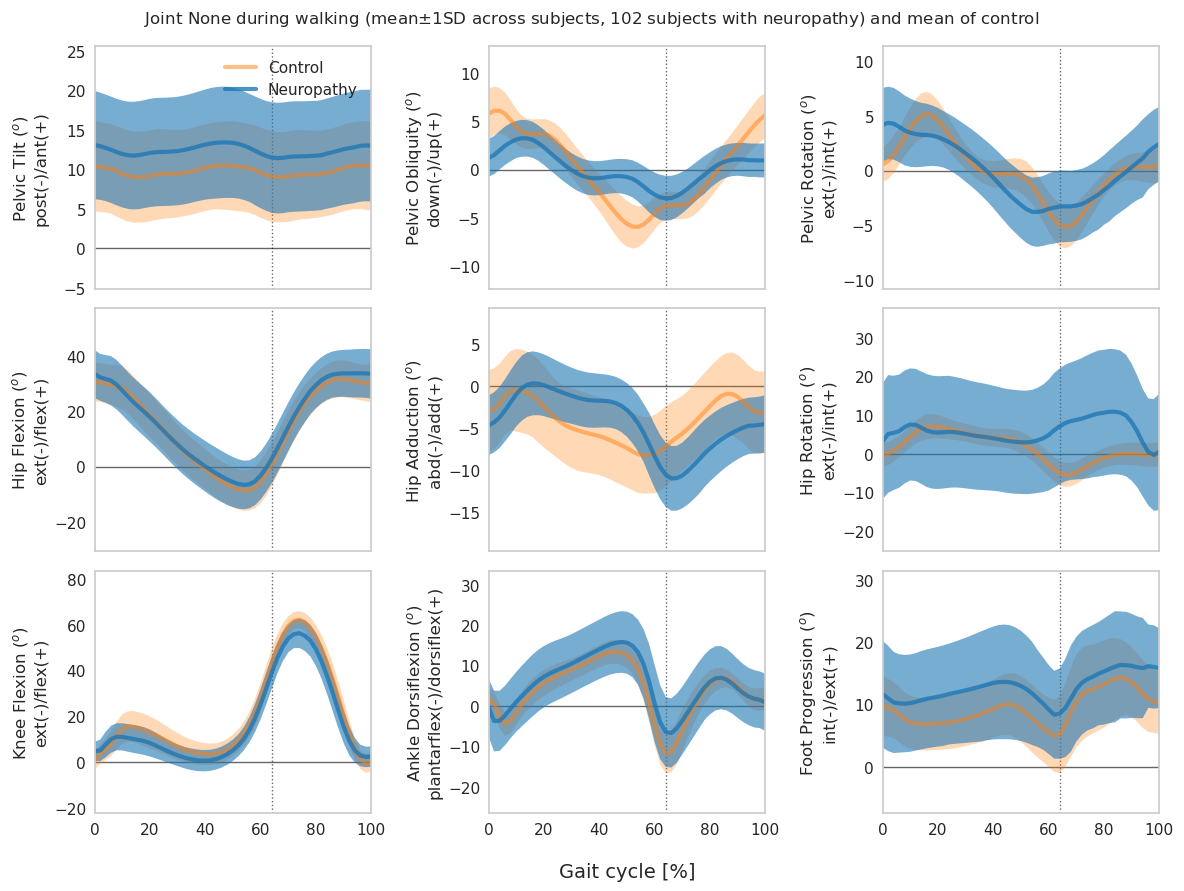

In [9]:
da2_kin = da_kin.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')

plot_ensembles(da2_kin, metadata, path2, mean=True, labels=labels_kin, ref=ref_data)

### GPS calculation

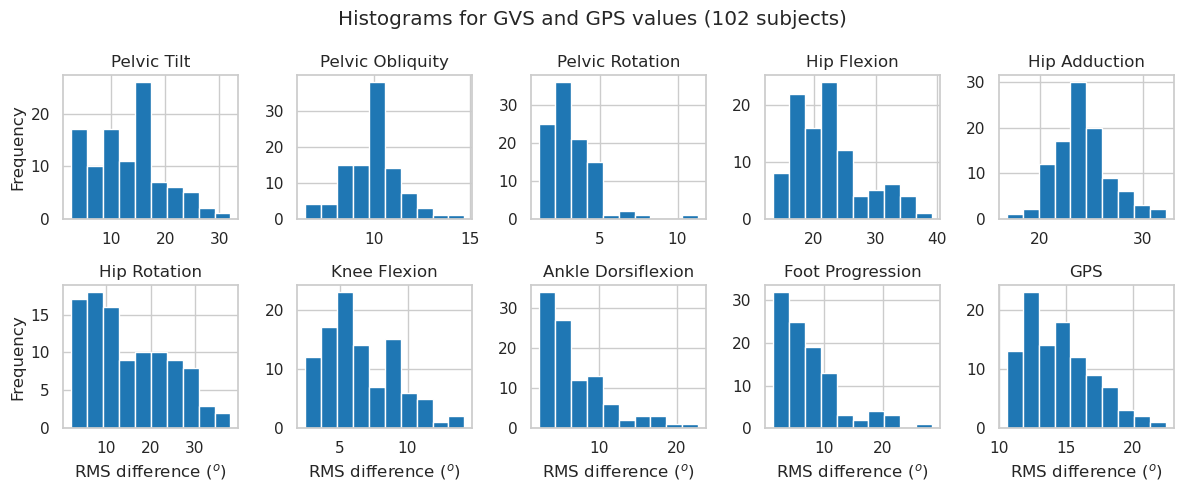

In [10]:
gvs_kin, gvs_m_kin, gvs_std_kin = gps_calc(da2_kin, ref_data_kin.iloc[:, 0::2],
                                           metadata, labels_gps=labels_gps_kin)
plot_gps(gvs_kin, gvs_m_kin, gvs_std_kin, metadata, path2, hist=True, MAP=False, units='$^o$')

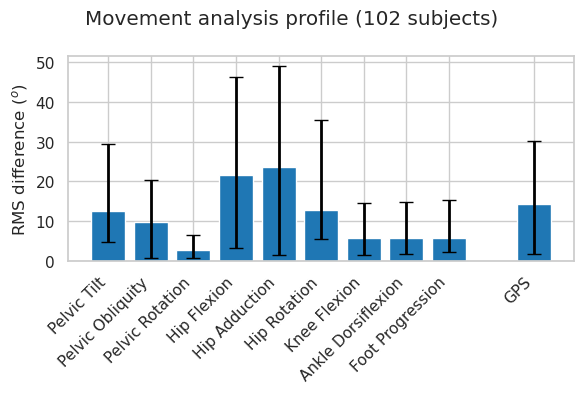

In [11]:
plot_gps(gvs_kin, gvs_m_kin, gvs_std_kin, metadata, path2, hist=False, MAP=True, units='$^o$')

In [12]:
gvs_kin.describe()

,Pelvic Tilt,Pelvic Obliquity,Pelvic Rotation,Hip Flexion,Hip Adduction,Hip Rotation,Knee Flexion,Ankle Dorsiflexion,Foot Progression,GPS
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,12.966776,9.891068,3.077070,22.211896,24.098379,15.268920,6.544470,7.029425,7.468893,14.490838
std,6.504640,1.366540,1.553675,5.654615,2.731582,9.030157,2.605743,4.224028,5.297195,2.571967
min,2.541195,6.415653,1.045229,13.376480,16.774726,2.071818,2.432654,2.314085,1.373294,10.576987
25%,8.013637,9.138040,2.095265,18.210937,22.231210,7.298083,4.478453,3.960416,3.621074,12.531249
50%,12.668452,9.918774,2.769572,21.523693,23.690212,12.886847,5.883206,5.773068,5.747758,14.247156
75%,16.895135,10.539426,3.702411,24.759325,25.453588,22.658516,8.639310,8.997993,9.495933,16.029316
max,32.039660,14.690897,11.337377,39.163258,32.240602,38.057659,14.197688,22.723626,28.326929,22.476485


## GPS kinetic

<xarray.DataArray 'Moment' (Time: 51, Joint: 3, Axis: 1, Trial: 10, Subject: 105)> Size: 1MB
[160650 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Hip' 'Knee' 'Ankle'
  * Axis     (Axis) object 8B 'ML'
Attributes:
    units:    Nm/(BM*H)

/home/marcos/miniconda3/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


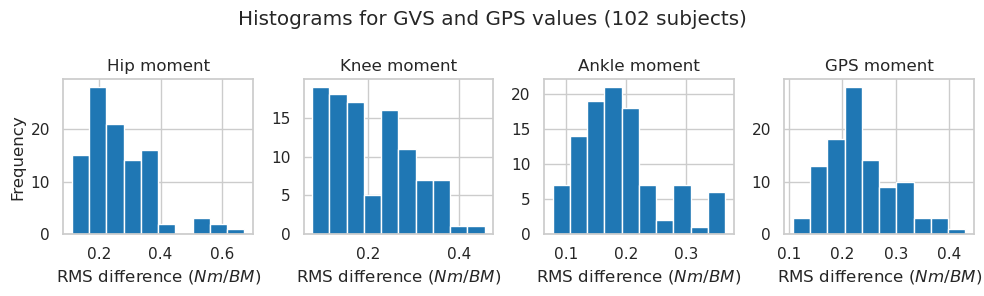

In [13]:
path2 = path / 'data'
variable = 'Moment'
metadata, da_mom = read_data(path2, fname='ERJ_T00', variable=variable)
da_mom = da_mom.sel(Joint=['Hip', 'Knee', 'Ankle'])
display(da_mom)

da2_mom = da_mom.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
gvs_mom, gvs_m_mom, gvs_std_mom = gps_calc(da2_mom, ref_data_mom.iloc[:, 0::2], metadata,
                                           labels_gps=labels_gps_mom)

plot_gps(gvs_mom, gvs_m_mom, gvs_std_mom, metadata, path2, hist=True, MAP=False, units='$Nm/BM$')

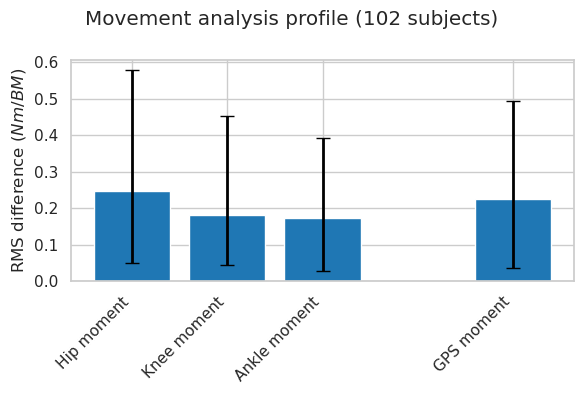

In [14]:
plot_gps(gvs_mom, gvs_m_mom, gvs_std_mom, metadata, path2, hist=False, MAP=True, units='$Nm/BM$')

In [15]:
gvs_mom.describe()

,Hip moment,Knee moment,Ankle moment,GPS moment
count,102.000000,102.000000,102.000000,102.000000
mean,0.269799,0.207346,0.188982,0.233965
std,0.110170,0.087873,0.067398,0.062059
min,0.110185,0.078519,0.078202,0.107596
25%,0.198240,0.137412,0.146324,0.189871
50%,0.246334,0.181160,0.172975,0.224591
75%,0.331226,0.270987,0.218534,0.268539
max,0.673450,0.455186,0.363889,0.429903


## GPS Statistics

### Correlation between GVS data

In [16]:
gvs_all = pd.concat([gvs_kin, gvs_mom], axis=1)
gvs_all

,Pelvic Tilt,Pelvic Obliquity,Pelvic Rotation,Hip Flexion,Hip Adduction,Hip Rotation,Knee Flexion,Ankle Dorsiflexion,Foot Progression,GPS,Hip moment,Knee moment,Ankle moment,GPS moment
C02,19.089106,9.773968,2.073211,26.678517,21.235813,10.338470,6.069881,4.889532,5.468926,14.237937,0.282024,0.189702,0.093913,0.203588
C04,28.516715,9.167665,2.941536,32.754722,25.031302,4.987714,9.061629,3.591588,4.682765,17.471112,0.333010,0.217361,0.125969,0.240839
C06,14.444943,9.824021,3.667358,24.813426,23.819398,14.955103,6.535049,8.206064,20.017465,15.762429,0.110185,0.096315,0.171322,0.130088
C07,14.914920,8.897739,3.181011,19.341492,22.099852,5.816189,3.761481,9.714289,7.728730,12.366252,0.238804,0.125318,0.161614,0.181522
C11,8.010841,8.342154,4.728054,16.687443,22.399208,11.147498,8.772760,4.112030,1.373294,11.334988,0.303560,0.209946,0.084506,0.218607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S60,32.039660,10.340857,2.637982,39.163258,30.215433,13.235807,5.354495,8.536537,8.283790,20.903259,0.155866,0.234878,0.237491,0.212809
S65,20.447055,10.419314,1.804364,29.295320,30.878329,20.242634,9.394558,4.009431,11.193474,18.199445,0.248622,0.257888,0.175420,0.230284
S68,15.513909,9.495019,2.721435,22.547661,23.549034,14.582736,5.762554,15.417241,4.487125,14.548333,0.144841,0.238656,0.218927,0.204829
S70,11.254714,8.439974,4.770356,20.181007,22.637791,29.652232,10.692516,6.684545,3.355265,15.598883,0.156116,0.331337,0.344782,0.290420


In [17]:
pg.pairwise_corr(gvs_all, method='pearson', padjust='holm')

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power
0,Pelvic Tilt,Pelvic Obliquity,pearson,two-sided,102,0.163202,"[-0.03, 0.35]",1.012234e-01,1.000000e+00,holm,0.465,0.376621
1,Pelvic Tilt,Pelvic Rotation,pearson,two-sided,102,0.005335,"[-0.19, 0.2]",9.575625e-01,1.000000e+00,holm,0.124,0.050169
2,Pelvic Tilt,Hip Flexion,pearson,two-sided,102,0.900653,"[0.86, 0.93]",5.601249e-38,5.097137e-36,holm,3.815e+34,1.000000
3,Pelvic Tilt,Hip Adduction,pearson,two-sided,102,0.308443,"[0.12, 0.47]",1.610461e-03,1.223950e-01,holm,16.67,0.889929
4,Pelvic Tilt,Hip Rotation,pearson,two-sided,102,0.182895,"[-0.01, 0.36]",6.577730e-02,1.000000e+00,holm,0.657,0.455561
...,...,...,...,...,...,...,...,...,...,...,...,...
86,Hip moment,Ankle moment,pearson,two-sided,102,-0.210214,"[-0.39, -0.02]",3.395099e-02,1.000000e+00,holm,1.136,0.568426
87,Hip moment,GPS moment,pearson,two-sided,102,0.693712,"[0.58, 0.78]",6.363409e-16,5.599800e-14,holm,1.171e+13,1.000000
88,Knee moment,Ankle moment,pearson,two-sided,102,0.560535,"[0.41, 0.68]",8.980169e-10,7.543342e-08,holm,1.333e+07,0.999994
89,Knee moment,GPS moment,pearson,two-sided,102,0.666494,"[0.54, 0.76]",2.076115e-14,1.806220e-12,holm,3.988e+11,1.000000


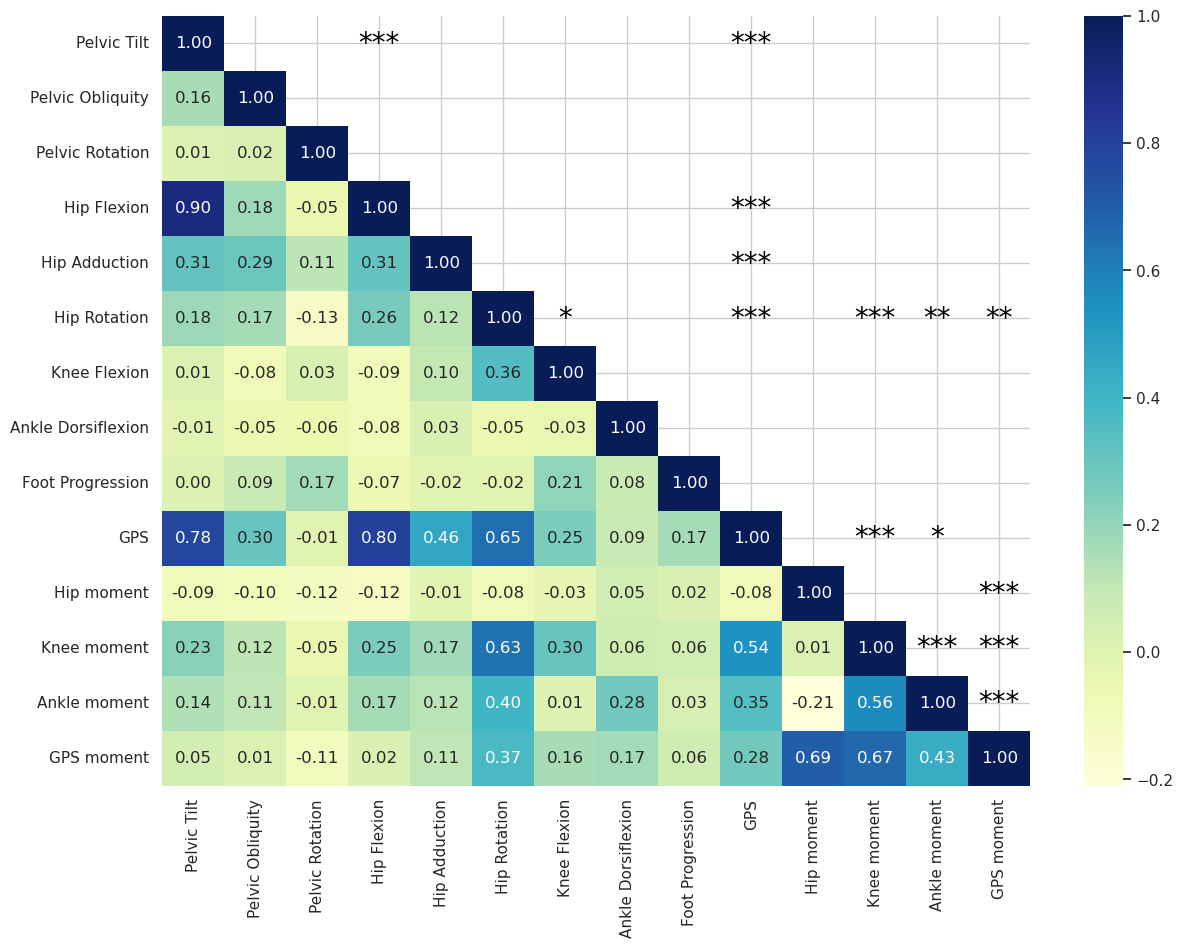

In [18]:
corr_heatmap(gvs_all, method='pearson', padjust='holm')

### Correlation with other evaluation data

In [19]:
info_erica = load_info(path2 / 'info_erica.xlsx')
info_rj = load_info(path2 / 'info_janeronaldo.xlsx')
info = pd.concat([info_erica, info_rj], axis=0)
info = pd.concat([info_erica, info_rj], axis=0)
info = info.loc[gvs_all.index]
info

,Age,Height,Mass,BMI,Sex,TDO,FuzzyScore,MNSI,EQ5D,FHSQFootPain,FHSQFootFunction
C02,60,1.60,85.2,33.281250,1,25,3.68,5,0.7368,56.250,68.75
C04,61,1.59,98.7,39.041177,1,25,3.94,5,0.5695,41.250,93.75
C06,58,1.67,77.6,27.824590,2,25,9.33,2,0.6167,96.875,68.75
C07,61,1.52,84.2,36.443906,1,37,3.68,7,0.5195,41.875,62.50
C11,59,1.70,75.5,26.124567,1,29,2.16,5,0.4828,29.375,43.75
...,...,...,...,...,...,...,...,...,...,...,...
S60,64,1.59,110.0,43.510937,1,2,2.16,8,0.4076,72.500,68.78
S65,47,1.58,109.8,43.983336,1,3,2.16,7,0.3627,37.500,50.00
S68,63,1.56,79.7,32.749836,1,17,2.16,6,1.0000,62.500,10.00
S70,64,1.67,83.7,30.011833,2,16,2.16,4,0.8012,87.500,100.00


In [20]:
info.describe()

,Age,Height,Mass,BMI,Sex,TDO,FuzzyScore,MNSI,EQ5D,FHSQFootPain,FHSQFootFunction
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,55.833333,1.641667,78.621569,29.254238,1.303922,14.794118,4.057647,6.382353,0.599789,45.422892,65.846176
std,8.621965,0.086289,15.509375,5.855896,0.462221,9.280383,2.297717,1.960219,0.173390,25.119170,27.994692
min,29.000000,1.480000,47.000000,17.306652,1.000000,2.000000,1.950000,2.000000,0.304500,0.000000,10.000000
25%,50.000000,1.580000,68.450000,25.641281,1.000000,8.000000,2.160000,5.000000,0.466750,23.593750,37.500000
50%,58.000000,1.635000,78.000000,29.087612,1.000000,13.500000,2.190000,6.000000,0.616700,41.875000,68.780000
75%,62.000000,1.700000,87.750000,32.678922,2.000000,20.000000,5.960000,7.000000,0.736800,66.718750,93.750000
max,71.000000,1.900000,116.000000,49.777778,2.000000,37.000000,9.330000,12.000000,1.000000,96.875000,100.000000


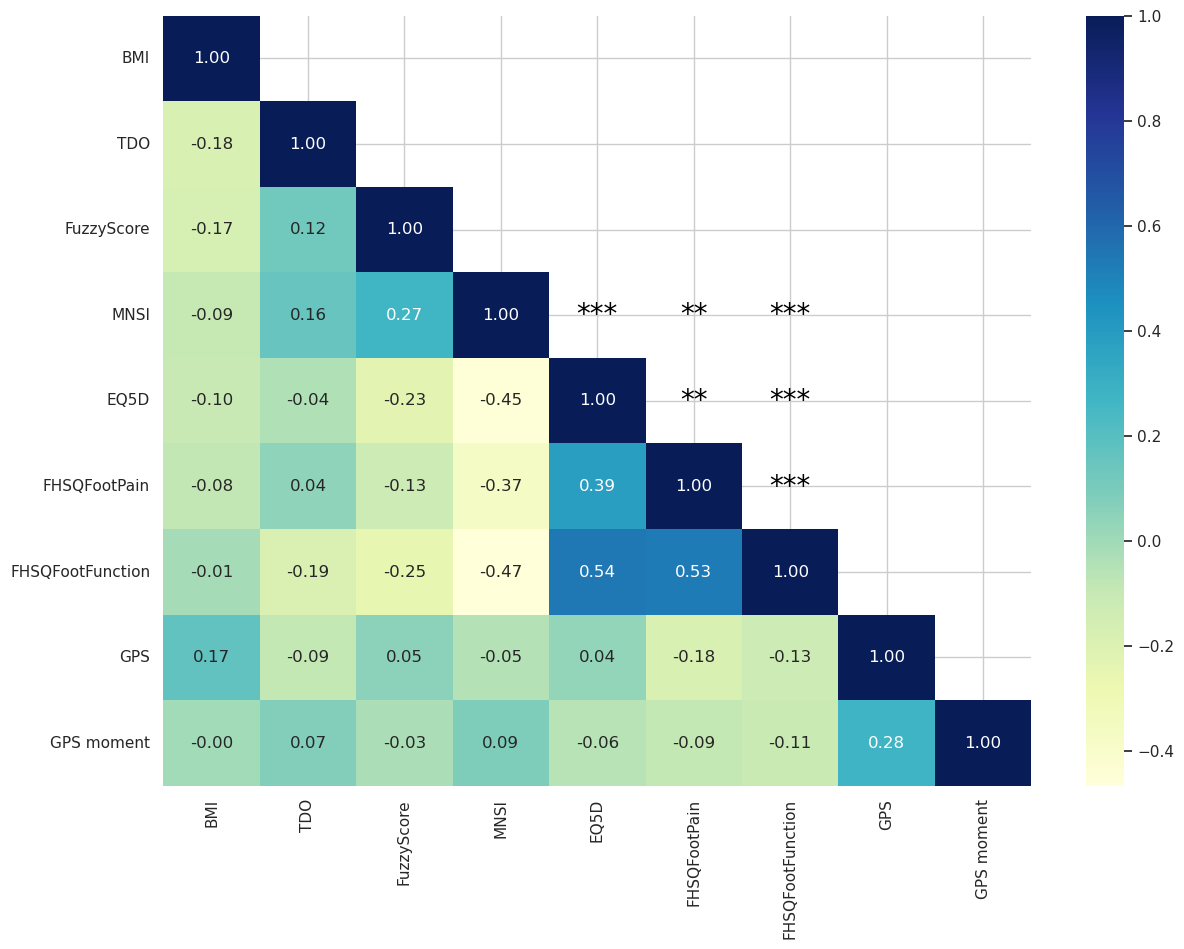

In [21]:
df = pd.concat([info[['BMI', 'TDO', 'FuzzyScore', 'MNSI', 'EQ5D', 'FHSQFootPain', 'FHSQFootFunction']],
                gvs_all[['GPS', 'GPS moment']]], axis=1)

corr_heatmap(df, method='pearson', padjust='holm')

The correlation values at the last two rows are all small. It doesn't appear that GPS values are correlated with the evaluation scores.

Let's expand the exploration and include all GVS values as well.

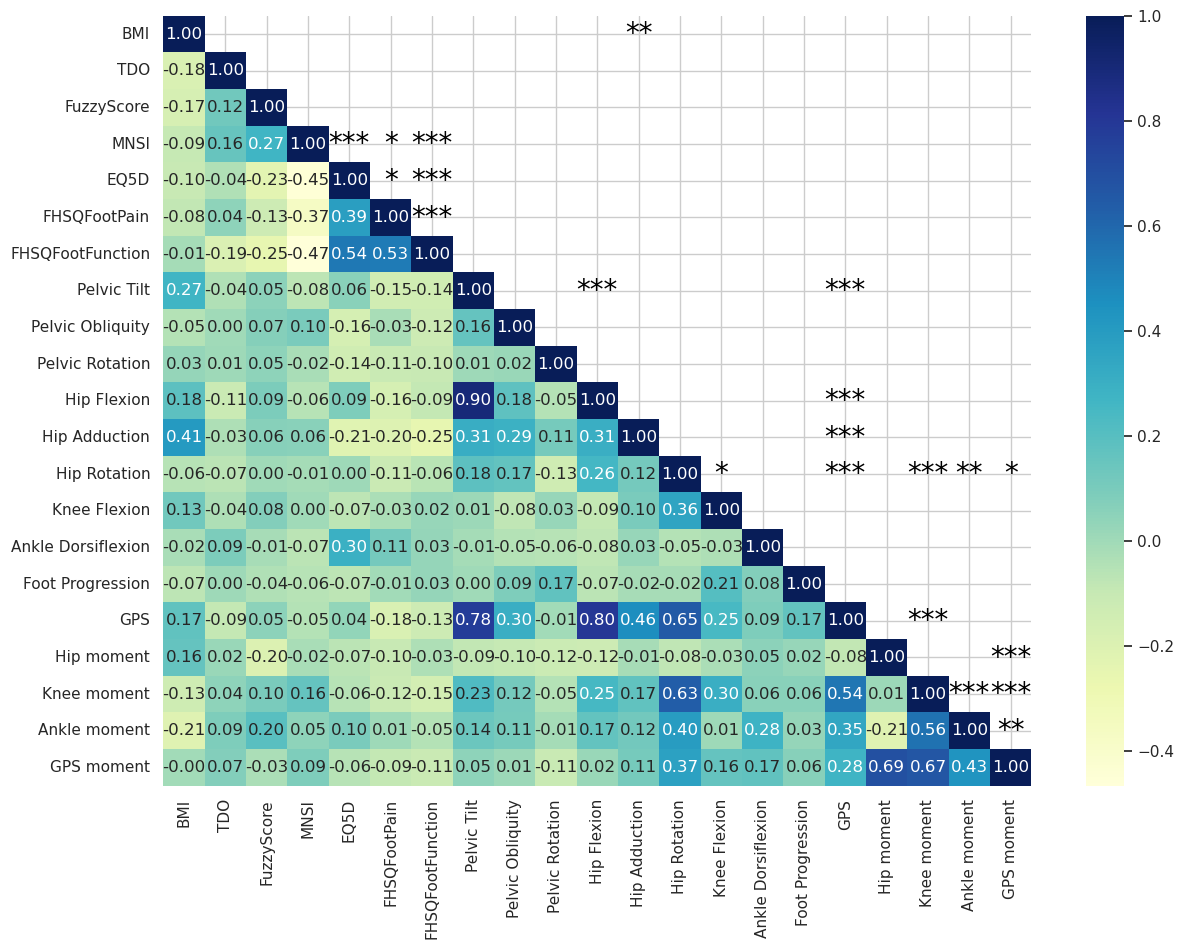

In [22]:
df = pd.concat([info[['BMI', 'TDO', 'FuzzyScore', 'MNSI', 'EQ5D', 'FHSQFootPain', 'FHSQFootFunction']],
                gvs_all], axis=1)

corr_heatmap(df, method='pearson', padjust='holm')

In [23]:
display(pg.pairwise_corr(df[['EQ5D', 'Ankle Dorsiflexion']], method='pearson', padjust='holm'))

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,EQ5D,Ankle Dorsiflexion,pearson,two-sided,102,0.298486,"[0.11, 0.47]",0.00231,12.027,0.867903


There are significant correlations between GVS Ankle Dorsiflexion and EQ5D score (r= .30).

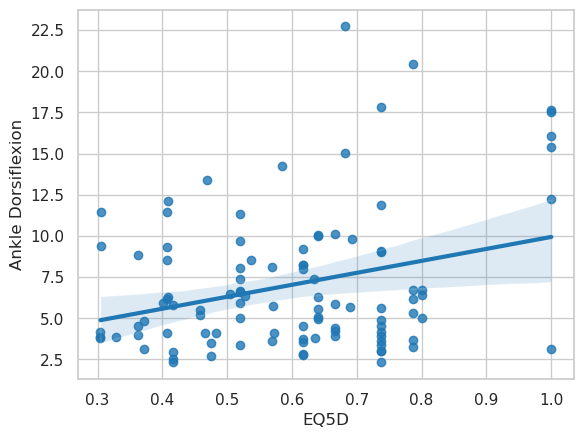

In [24]:
sns.regplot(data=df, x='EQ5D', y='Ankle Dorsiflexion')
plt.show()

## Descriptive statistics for the datasets

### Root-mean-square deviation (RMSD)

The root-mean-square deviation (RMSD) is the square root of the average of squared deviations between two samples $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$

### Relative root-mean-square deviation (RMSD rel)

The relative RMSD in percentage (RMSD rel) is the RMSD divided by the absolute mean (AM) between two samples $x$ and $y$ times 100, where AM is:

$$ \mathrm{AM} = \sum_{i=1}^N \frac{|x_i|+|y_i|}{2N} $$

### Absolute maximum difference (AMD)

The maximum difference (AMD) between two samples $x$ and $y$ is:

$$ \mathrm{AMD} = \max \{ |x-y| \} $$

### Relative absolute maximum difference (AMD rel)

The relative maximum difference in percentage (AMD rel) is the AMD divided by the absolute mean (AM) times 100.

In [25]:
ref_all = np.load(file=path2_ref/'angles_mom_all_ref_claudiane.npy')
ref_kin = ref_all[:, :9, :]
ref_mom = ref_all[:, 9:-1, :]
erj_kin = da2_kin.values.reshape((51, 9, 105))
erj_mom = da2_mom.values.squeeze(axis=2)

In [26]:
groups = ['Control', 'Neuropathy']
ang_all = np.full([ref_kin.shape[0], ref_kin.shape[1], np.max([ref_kin.shape[2], erj_kin.shape[2]]), len(groups)], np.nan)
ang_all[:, :, :ref_kin.shape[2], 0] = ref_kin
ang_all[:, :, :erj_kin.shape[2], 1] = erj_kin
ang_m  = np.nanmean(ang_all, axis=2)
ang_sd = np.nanstd(ang_all, axis=2, ddof=0)  # use ddof=0 to compute RMS

In [27]:
#@title #### Table with results {display-mode: "form"}
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays
AMD  = lambda x, y: np.nanmax(np.abs(y - x), axis=0)  #  x and y must be arrays
AM   = lambda x: np.nanmean(np.nanmean(np.abs(x), axis=2), axis=0)  #  x must be 3d arrays

# inter-group stats
rmsd = RMSD(ang_m[:, :, 0], ang_m[:, :, 1])
am = AM(ang_m)
rmsd_r = rmsd/am * 100
amd = AMD(ang_m[:, :, 0], ang_m[:, :, 1])
amd_r = amd/am * 100
# intra-group stats
rmsd_i = np.sqrt(np.mean((ang_sd**2), axis=0))
rmsd_i_rel = rmsd_i / np.nanmean(np.abs(ang_m), axis=0) * 100
stats = pd.DataFrame({'AMD [deg]': amd, 'AMD rel [%]': amd_r,
                      'RMSD [deg]': rmsd, 'RMSD rel [%]': rmsd_r,
                      'RMSD [deg]': rmsd, 'RMSD rel [%]': rmsd_r},
                     index=labels_gps_kin[:-1])
for g, group in enumerate(groups):
    stats[f'RMSD_{group[0]} [deg]'] = rmsd_i[:, g]
    stats[f'RMSD_{group[0]} rel [%]'] = rmsd_i_rel[:, g]
stats['RMSD_All [deg]'] = np.mean(rmsd_i, axis=1)
stats['RMSD_All rel [%]'] = np.mean(rmsd_i_rel, axis=1)

display(stats.style.format('{:.1f}'))
display(stats.describe().T.style.format('{:.1f}'))

df = pd.DataFrame()
vs = [['RMSD [deg]', 'RMSD_All [deg]'], ['RMSD rel [%]', 'RMSD_All rel [%]']]
for v in vs:
    ttest = pg.ttest(stats[v[0]], stats[v[1]])
    ttest.rename(index={'T-test': v[0]}, inplace=True)
    df = pd.concat([df, ttest], axis=0)
df.drop(columns=['alternative', 'BF10', 'power'], inplace=True)
df.index.name = 'Inter-Intra'
display(df)

,AMD [deg],AMD rel [%],RMSD [deg],RMSD rel [%],RMSD_C [deg],RMSD_C rel [%],RMSD_N [deg],RMSD_N rel [%],RMSD_All [deg],RMSD_All rel [%]
Pelvic Tilt,2.9,26.6,2.6,23.8,5.5,56.8,6.9,55.6,6.2,56.2
Pelvic Obliquity,4.9,197.5,2.5,101.5,1.9,54.5,1.9,127.3,1.9,90.9
Pelvic Rotation,3.6,161.9,1.5,66.9,1.5,73.6,3.1,126.3,2.3,99.9
Hip Flexion,3.5,20.1,1.8,10.5,7.2,41.5,8.8,49.4,8.0,45.5
Hip Adduction,5.2,123.2,3.6,85.7,4.7,113.8,3.6,83.3,4.1,98.6
Hip Rotation,13.8,306.2,6.8,151.0,2.8,87.3,14.5,248.1,8.6,167.7
Knee Flexion,6.1,32.3,4.0,21.3,5.5,26.7,5.8,33.4,5.6,30.0
Ankle Dorsiflexion,5.4,81.1,2.5,37.9,3.4,52.6,7.7,112.4,5.6,82.5
Foot Progression,5.6,50.8,3.6,32.4,5.4,57.4,8.2,64.5,6.8,60.9


,count,mean,std,min,25%,50%,75%,max
AMD [deg],9.0,5.7,3.2,2.9,3.6,5.2,5.6,13.8
AMD rel [%],9.0,111.1,96.4,20.1,32.3,81.1,161.9,306.2
RMSD [deg],9.0,3.2,1.6,1.5,2.5,2.6,3.6,6.8
RMSD rel [%],9.0,59.0,46.4,10.5,23.8,37.9,85.7,151.0
RMSD_C [deg],9.0,4.2,1.9,1.5,2.8,4.7,5.5,7.2
RMSD_C rel [%],9.0,62.7,25.8,26.7,52.6,56.8,73.6,113.8
RMSD_N [deg],9.0,6.7,3.8,1.9,3.6,6.9,8.2,14.5
RMSD_N rel [%],9.0,100.0,65.2,33.4,55.6,83.3,126.3,248.1
RMSD_All [deg],9.0,5.5,2.3,1.9,4.1,5.6,6.8,8.6
RMSD_All rel [%],9.0,81.4,40.6,30.0,56.2,82.5,98.6,167.7


,T,dof,p-val,CI95%,cohen-d
Inter-Intra,,,,,
RMSD [deg],-2.380950,16,0.030036,"[-4.22, -0.24]",1.122391
RMSD rel [%],-1.089258,16,0.292175,"[-65.9, 21.17]",0.513481


**The average variability inter-groups (RMSD = 3.2±1.6 deg) is lower than the variability intra-laboratories (RMSD Control = 4.2±1.9 deg, RMSD Neuropathy = 6.7±3.8 deg)**.

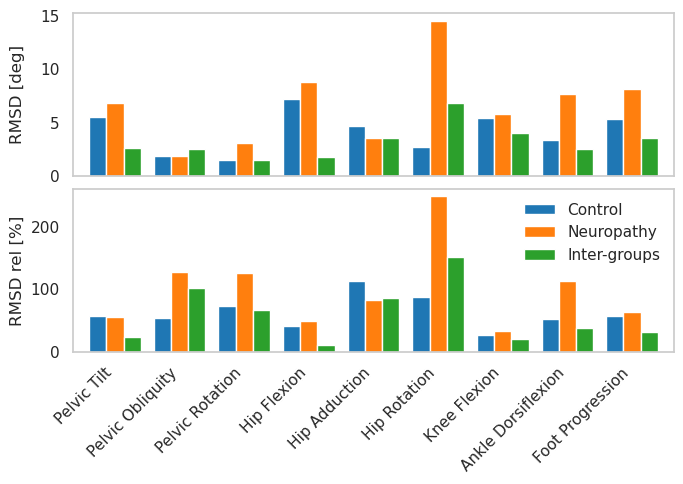

In [28]:
#@title #### Plot of results {display-mode: "form"}

fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
stats.iloc[:, [4, 6, 2]].plot.bar(ax=axs[0], width=.8, edgecolor=None, legend=False)
stats.iloc[:, [5, 7, 3]].plot.bar(ax=axs[1], width=.8, edgecolor=None)
axs[0].set_ylabel('RMSD [deg]')
axs[1].set_ylabel('RMSD rel [%]')
axs[1].set_xlabel('')
axs[1].set_xticklabels(labels_gps_kin[:-1], rotation=45, ha='right')
axs[0].grid(False)
axs[1].grid(False)
fig.align_ylabels(axs)
legend = groups.copy()
legend.extend(['Inter-groups'])
axs[1].legend(legend, loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.2)
plt.show()

### Inference using Statistical Parametric Mapping (SPM)

Statistical Parametric Mapping uses random field theory to make statistical inferences regarding registered (normalized) sets of 1D measurements. See [https://spm1d.org/index.html](https://spm1d.org/index.html).

In [30]:
#@title #### SPM1d inferences {display-mode: "form"}

spm_t = np.empty(9, dtype=np.object_)
spm_ti = spm_t.copy()
for a, angle in enumerate(labels_gps_kin[:-1]):
    ang_c = ang_all[:, a, :, 0].T
    ang_c = ang_c[~np.isnan(ang_c).any(axis=1)]
    ang_n = ang_all[:, a, :, 1].T
    ang_n = ang_n[~np.isnan(ang_n).any(axis=1)]
    spm_t[a]  = spm1d.stats.ttest2(ang_c, ang_n, equal_var=False)
    spm_ti[a] = spm_t[a].inference(alpha=0.05, two_tailed=True, interp=True)
    print(angle, '\n', spm_ti[a])

#fig.tight_layout(w_pad=.1)

Pelvic Tilt 
 SPM{t} inference field
   SPM.z         :  (1x51) raw test stat field
   SPM.df        :  (1, 135.820)
   SPM.fwhm      :  60.31675
   SPM.resels    :  (1, 0.82896)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.34584
   SPM.h0reject  :  True
   SPM.p_set     :  0.001
   SPM.p_cluster :  (0.049, 0.044)



Pelvic Obliquity 
 SPM{t} inference field
   SPM.z         :  (1x51) raw test stat field
   SPM.df        :  (1, 139.967)
   SPM.fwhm      :  12.17637
   SPM.resels    :  (1, 4.10631)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.83199
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (0.025, 0.017, 0.002, 0.021, 0.023)



Pelvic Rotation 
 SPM{t} inference field
   SPM.z         :  (1x51) raw test stat field
   SPM.df        :  (1, 117.716)
   SPM.fwhm      :  15.65916
   SPM.resels    :  (1, 3.19302)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.75734
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.

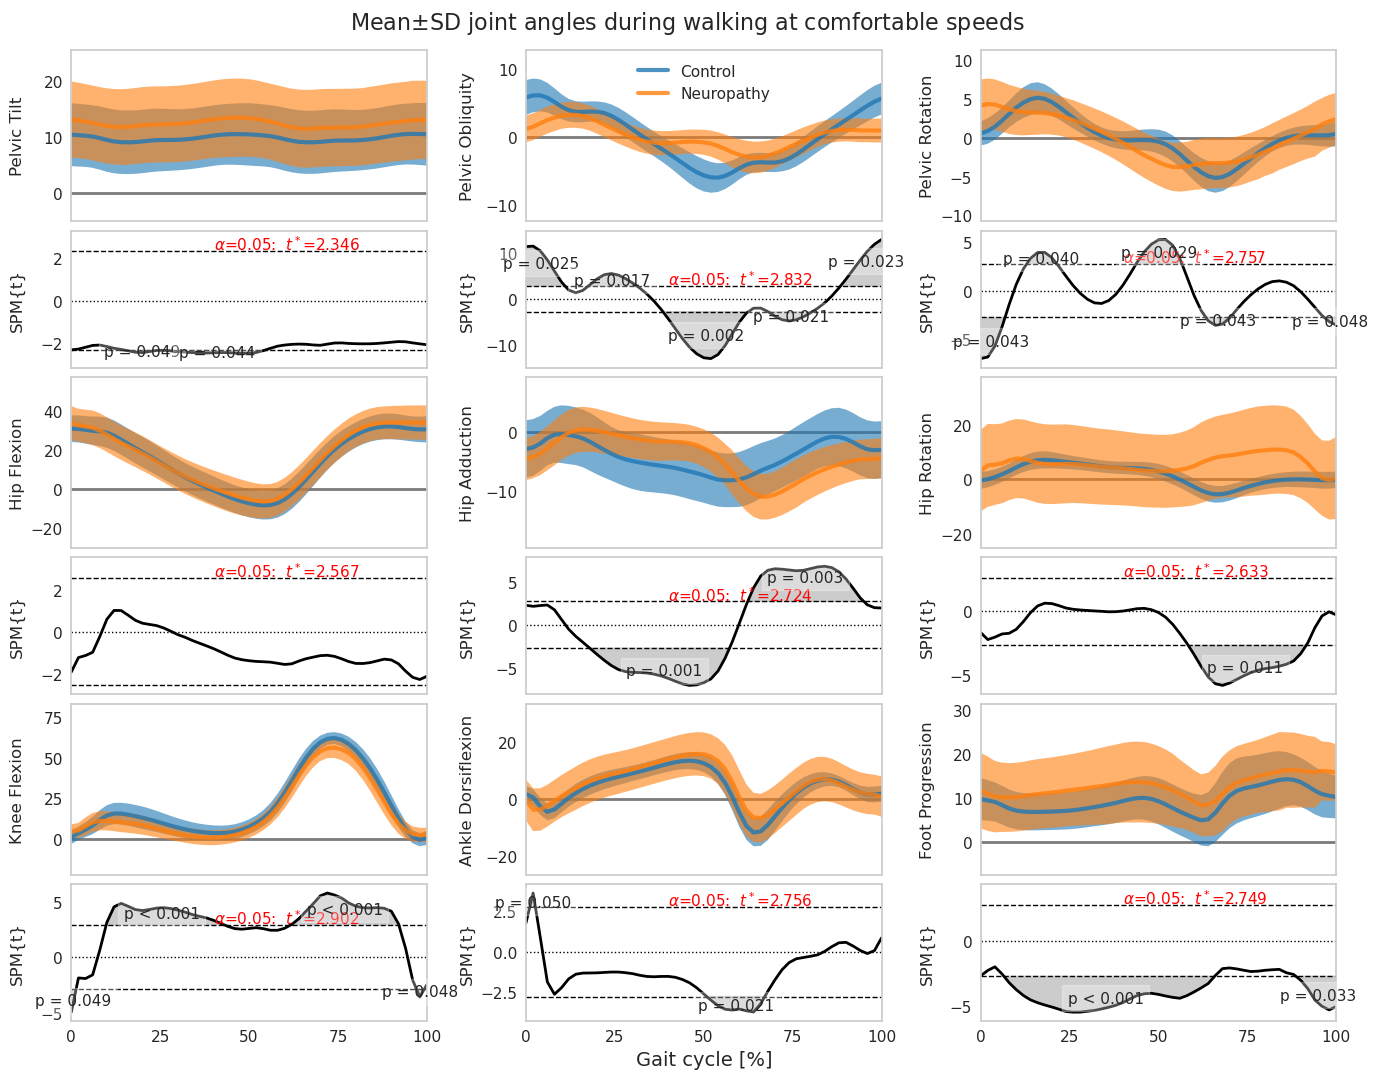

In [31]:
#@title #### Plot {display-mode: "form"}

tn = np.linspace(0, 100, 51)

# spm1d p-values offsets in plots
offsets = [None, [(15, -1), (0, -3), (-15, -1)], [(16, 1), (-10, -2.5)],
           None, None, [(17, 2), (-5, 2)], None, [(15, +2)], None]

heights = [1, .8, 1, .8, 1, .8]
widths  = [1, 1, 1]
fig, axs = plt.subplots(6, 3, figsize=(14, 11), sharex=False,
                        gridspec_kw={'height_ratios': heights, 'width_ratios': widths})
axs = axs.flatten()
rangs = np.array([0, 1, 2, 6, 7, 8, 12, 13, 14])
rspms = rangs + 3
fig.suptitle(f'Mean$\\pm$SD joint angles during walking at comfortable speeds', fontsize=16)
for a, angle in enumerate(labels_gps_kin[:-1]):
    for g, group in enumerate(groups):
        axs[rangs[a]].axhline(y=0, color=[0, 0, 0, .3], linestyle='-', zorder=-1)
        axs[rangs[a]].plot(tn, ang_m[:, a, g], label=group, color=colors[g], alpha=.8, lw=3)
        axs[rangs[a]].fill_between(tn,
                                       ang_m[:, a, g] + ang_sd[:, a, g],
                                       ang_m[:, a, g] - ang_sd[:, a, g],
                                       facecolor=colors[g], alpha=.6, edgecolor='none')

    # spm1d plots
    spm_ti[a].plot(ax=axs[rspms[a]], color='k', plot_ylabel=False)
    spm_ti[a].plot_threshold_label(ax=axs[rspms[a]], size=11)
    spm_ti[a].plot_p_values(ax=axs[rspms[a]], size=11)  # , offsets=offsets[a]

    axs[rangs[a]].set_ylabel(angle)
    axs[rspms[a]].set_ylabel('SPM{t}', fontsize=12)
    axs[rangs[a]].set_xlim([0, 100])
    axs[rspms[a]].set_xlim([0, 50])
    axs[rangs[a]].margins(y=0.25)
    axs[rangs[a]].grid(False), axs[rspms[a]].grid(False)
    axs[rangs[a]].xaxis.set_visible(False)
    if a < 6:
        axs[rspms[a]].xaxis.set_visible(False)
    axs[rangs[a]].tick_params(axis='both', which='major', pad=0)
    axs[rspms[a]].tick_params(axis='both', which='major', pad=0)
    if a == 7:
        axs[rspms[a]].set_xlabel('Gait cycle [%]', fontsize=14)
    axs[rangs[a]].set_xlabel('')
    if a < 6:
        axs[rspms[a]].set_xlabel('')
    else:
        axs[rspms[a]].set_xticks(np.array([0, 25, 50, 75, 100])/2) 
        axs[rspms[a]].set_xticklabels([0, 25, 50, 75, 100])                

fig.align_ylabels()
axs[1].legend(loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.3, w_pad=.05)
try:
    fig.savefig(f'{path2}{os.sep}labs_angs_spm.png', bbox_inches='tight')
except:
    print('Figure not saved in the cloud.')
plt.show()